In [8]:
import cv2
from skimage.filters import threshold_local
import imutils
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt

In [9]:
plate_path = "plates_images/data/16.png"
fixed_width = 400
image = cv2.imread(plate_path)

In [10]:
cv2.imshow("plate 1",image)
cv2.waitKey(0)
cv2.destroyAllWindows()
fixed_width=400

In [11]:
def sort_cont(character_contours):
    """
    To sort contours from left to right
    """
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in character_contours]
    (character_contours, boundingBoxes) = zip(*sorted(zip(character_contours, boundingBoxes),
                                                      key=lambda b: b[1][i], reverse=False))
    return character_contours


In [12]:
def segment_chars(plate_img, fixed_width):
    """
        ******************
    """
    V = cv2.split(cv2.cvtColor(plate_img, cv2.COLOR_BGR2HSV))[2]

    T = threshold_local(V, 29, offset=15, method='gaussian')

    thresh = (V > T).astype('uint8') * 255

    thresh = cv2.bitwise_not(thresh)

    # resize the license plate region to a canoncial size
    plate_img = imutils.resize(plate_img, width=fixed_width)
    thresh = imutils.resize(thresh, width=fixed_width)
    bgr_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

    # perform a connected components analysis and initialize the mask to store the locations
    # of the character candidates
    labels = measure.label(thresh, 8, 0)

    charCandidates = np.zeros(thresh.shape, dtype='uint8')

    # loop over the unique components
    characters = []
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask to display only connected components for the
        # current label, then find contours in the label mask
        labelMask = np.zeros(thresh.shape, dtype='uint8')
        labelMask[labels == label] = 255

        cnts = cv2.findContours(
            labelMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0]

        # ensure at least one contour was found in the mask
        if len(cnts) > 0:

            # grab the largest contour which corresponds to the component in the mask, then
            # grab the bounding box for the contour
            c = max(cnts, key=cv2.contourArea)
            # c = max([area for area in cv2.contourArea(cnts) if cnts !=0 ])
            (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)

            # compute the aspect ratio, solodity, and height ration for the component
            aspectRatio = boxW / float(boxH)
            solidity = cv2.contourArea(c) / float(boxW * boxH)
            heightRatio = boxH / float(plate_img.shape[0])

            # determine if the aspect ratio, solidity, and height of the contour pass
            # the rules tests
            keepAspectRatio = aspectRatio < 1.0
            keepSolidity = solidity > 0.15
            keepHeight = heightRatio > 0.5 and heightRatio < 0.95

            # check to see if the component passes all the tests
            if keepAspectRatio and keepSolidity and keepHeight and boxW > 14:
                # compute the convex hull of the contour and draw it on the character
                # candidates mask
                hull = cv2.convexHull(c)

                cv2.drawContours(charCandidates, [hull], -1, 255, -1)

    contours, hier = cv2.findContours(
        charCandidates, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contours = sort_cont(contours)
        addPixel = 4  # value to be added to each dimension of the character
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            if y > addPixel:
                y = y - addPixel
            else:
                y = 0
            if x > addPixel:
                x = x - addPixel
            else:
                x = 0
            temp = bgr_thresh[y:y + h +
                              (addPixel * 2), x:x + w + (addPixel * 2)]

            characters.append(temp)
        return characters
    else:
        return None

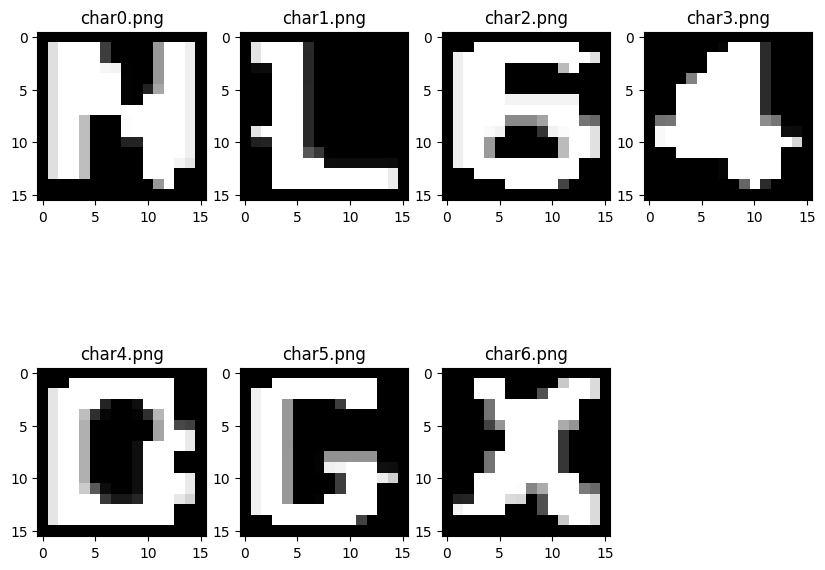

In [13]:
caracters = segment_chars(plate_img=image, fixed_width=fixed_width)

fig = plt.figure(figsize=(10, 8))
columns = 4
rows = 2
for i, car in enumerate(caracters):
    fig.add_subplot(rows, columns, i+1)
    plt.title("char%d.png" % (i))
    plt.imshow(cv2.resize(car,(16,16)))
plt.show()